In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from dwave.system import LeapHybridCQMSampler
from dimod import BQM
from dimod import CQM
import matplotlib.cm as cm
import matplotlib.colors as colors

# Assumption
Currently For simplifying the problem , I have assumed vehicle can change move one node to another node in any direction or I have considered undirected graph to solve the proble 

In [43]:
def generate_connected_undirected_graph(num_nodes, extra_edges=5):
    G = nx.Graph()

    # Start by generating a spanning tree (ensuring the graph is connected)
    for i in range(1, num_nodes):
        u = i
        v = random.randint(0, i-1)  # Connect the current node to any of the previous nodes
        weight = round(random.uniform(0.1, 1),1)  # Floating-point weight between 0 and 1
        G.add_edge(u, v, weight=weight)

    # Add extra random edges to increase graph complexity
    edges_added = 0
    while edges_added < extra_edges:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v and not G.has_edge(u, v):
            weight = round(random.uniform(0.1, 1), 1)  # Floating-point weight between 0 and 1
            G.add_edge(u, v, weight=weight)
            edges_added += 1

    return G

# Function to plot the undirected graph
def plot_undirected_graph(G):
    pos = nx.spring_layout(G)
    weights = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
    plt.show()

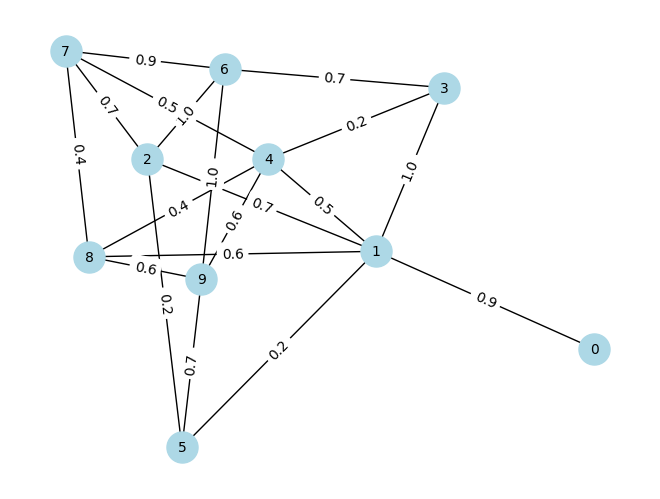

In [64]:
G = generate_connected_undirected_graph(10, 10)
plot_graph(G)

In [59]:
nx.to_numpy_array(G, weight='weight')

array([[0. , 0.3, 0.5, 0.8, 0.2, 0. , 0. , 0. , 1. , 0.5],
       [0.3, 0. , 0.4, 0. , 0. , 0.2, 0.6, 0. , 0. , 0.1],
       [0.5, 0.4, 0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0.8, 0. , 0. , 0. , 0.2, 1. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0.4, 0.2, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 1. , 0. , 0. , 0. , 1. , 0.9, 0.2],
       [0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.7, 0.8, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0.7, 0. , 0. , 0.9],
       [1. , 0. , 0. , 0. , 0. , 0.9, 0.8, 0. , 0. , 0. ],
       [0.5, 0.1, 0. , 0. , 0. , 0.2, 0. , 0.9, 0. , 0. ]])

### Classical Approach 
For finding 3 optimal alternative path

In [85]:
def find_shortest_path_with_penalty_directed(G, source, target, penalty_factor):
    # Make a deep copy of the graph so we can modify weights without affecting the original graph
    H = G.copy()
    
    # Find the shortest path using the original weights
    shortest_path = nx.shortest_path(H, source=source, target=target, weight='weight', method='dijkstra')
    path_length = round(nx.shortest_path_length(H, source=source, target=target, weight='weight'), 2)
    
    # Apply penalty to the selected path
    for i in range(len(shortest_path) - 1):
        u, v = shortest_path[i], shortest_path[i + 1]
        if H.has_edge(u, v):
            H[u][v]['weight'] += round(penalty_factor*H[u][v]['weight'], 2)  # Increase the weight by a penalty

    return shortest_path, path_length, H

# Function to find the top 3 paths with penalties for directed graph
def find_top_k_paths_directed(G, source, target, k=3, penalty_factor=10):
    paths = []
    modified_graph = G.copy()

    for i in range(k):
        path, length, modified_graph = find_shortest_path_with_penalty_directed(modified_graph, source, target, penalty_factor)
        paths.append((path, length))

    return paths

### Penalty Factor
It is hyperparameter to ensure that when we are choosing 3 possible path , there is minimum overlap between any two paths for same vehicle

It is not a efficient way to find out the possible way , it will consume a lot of time as number vehicles increases 

Other approach can be to save all the routes , but it will take lot of space (as unique pairs of source and destination increase), so we have to calculate it on the fly for that we can optimize the above algorithm or can find other way

In [309]:
source, target = 0, 9
top_paths_directed = find_top_k_paths_directed(G, source, target, penalty_factor =0.5)

# Display the paths
for idx, (path, length) in enumerate(top_paths_directed):
    print(f"Path {idx + 1}: {path}, Length: {length}")

Path 1: [0, 1, 5, 9], Length: 1.8
Path 2: [0, 1, 4, 9], Length: 2.45
Path 3: [0, 1, 8, 9], Length: 3.23


### Generating Input Data for 6 Vehicles 

In [279]:
user_input = [(0,9), (0,2), (2,9), (1, 2), (2, 1), (1, 2)]

In [280]:
optimal_paths = []
for idx, (source, target) in enumerate(user_input):
    path = find_top_k_paths_directed(G, source, target, penalty_factor =0.5)
    optimal_paths.append(path)
    print(f"Optimal Paths for User {idx + 1}: {path}")

Optimal Paths for User 1: [([0, 1, 5, 9], 1.8), ([0, 1, 4, 9], 2.45), ([0, 1, 8, 9], 3.23)]
Optimal Paths for User 2: [([0, 1, 5, 2], 1.3), ([0, 1, 5, 2], 1.95), ([0, 1, 2], 2.73)]
Optimal Paths for User 3: [([2, 5, 9], 0.9), ([2, 5, 9], 1.35), ([2, 7, 8, 9], 1.7)]
Optimal Paths for User 4: [([1, 5, 2], 0.4), ([1, 5, 2], 0.6), ([1, 2], 0.7)]
Optimal Paths for User 5: [([2, 5, 1], 0.4), ([2, 5, 1], 0.6), ([2, 1], 0.7)]
Optimal Paths for User 6: [([1, 5, 2], 0.4), ([1, 5, 2], 0.6), ([1, 2], 0.7)]


In [281]:
optimal_paths

[[([0, 1, 5, 9], 1.8), ([0, 1, 4, 9], 2.45), ([0, 1, 8, 9], 3.23)],
 [([0, 1, 5, 2], 1.3), ([0, 1, 5, 2], 1.95), ([0, 1, 2], 2.73)],
 [([2, 5, 9], 0.9), ([2, 5, 9], 1.35), ([2, 7, 8, 9], 1.7)],
 [([1, 5, 2], 0.4), ([1, 5, 2], 0.6), ([1, 2], 0.7)],
 [([2, 5, 1], 0.4), ([2, 5, 1], 0.6), ([2, 1], 0.7)],
 [([1, 5, 2], 0.4), ([1, 5, 2], 0.6), ([1, 2], 0.7)]]

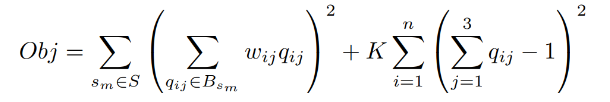

#### In Actual Equation there is weight assign to each path for each vehicle according to their emergency and their preference over other path

#### But for simplification , I am omitting this wij variable

In [282]:
# Function to create the dictionary from paths
def create_edge_dict(all_paths):
    edge_dict = {}
    
    for vehicle_num, paths in enumerate(all_paths):
        for path_num, (path, l) in enumerate(paths): 
            for i in range(len(path) - 1):
                u = path[i]
                v = path[i + 1]
                key = f"{min(u, v)}_{max(u, v)}"
                if key not in edge_dict:
                    edge_dict[key] = []  # Initialize the list if the key doesn't exist
                edge_dict[key].append(f"v_{vehicle_num}_{path_num}")  # Append vehicle and path info

    return edge_dict

In [283]:
qubo_dict = create_edge_dict(optimal_paths)

In [284]:
qubo_dict

{'0_1': ['v_0_0', 'v_0_1', 'v_0_2', 'v_1_0', 'v_1_1', 'v_1_2'],
 '1_5': ['v_0_0',
  'v_1_0',
  'v_1_1',
  'v_3_0',
  'v_3_1',
  'v_4_0',
  'v_4_1',
  'v_5_0',
  'v_5_1'],
 '5_9': ['v_0_0', 'v_2_0', 'v_2_1'],
 '1_4': ['v_0_1'],
 '4_9': ['v_0_1'],
 '1_8': ['v_0_2'],
 '8_9': ['v_0_2', 'v_2_2'],
 '2_5': ['v_1_0',
  'v_1_1',
  'v_2_0',
  'v_2_1',
  'v_3_0',
  'v_3_1',
  'v_4_0',
  'v_4_1',
  'v_5_0',
  'v_5_1'],
 '1_2': ['v_1_2', 'v_3_2', 'v_4_2', 'v_5_2'],
 '2_7': ['v_2_2'],
 '7_8': ['v_2_2']}

In [285]:
bqm = BQM("BINARY")

In [286]:
for edge , vehicles in qubo_dict.items():
    pen = []
    for v in vehicles:
        bqm.add_linear(f"{v}", 1)
        for ov in pen:
            bqm.add_quadratic(f"{v}", f"{ov}", 2)
        pen.append(v)

In [287]:
bqm

BinaryQuadraticModel({'v_0_0': 3.0, 'v_0_1': 3.0, 'v_0_2': 3.0, 'v_1_0': 3.0, 'v_1_1': 3.0, 'v_1_2': 2.0, 'v_3_0': 2.0, 'v_3_1': 2.0, 'v_4_0': 2.0, 'v_4_1': 2.0, 'v_5_0': 2.0, 'v_5_1': 2.0, 'v_2_0': 2.0, 'v_2_1': 2.0, 'v_2_2': 3.0, 'v_3_2': 1.0, 'v_4_2': 1.0, 'v_5_2': 1.0}, {('v_0_1', 'v_0_0'): 2.0, ('v_0_2', 'v_0_0'): 2.0, ('v_0_2', 'v_0_1'): 2.0, ('v_1_0', 'v_0_0'): 4.0, ('v_1_0', 'v_0_1'): 2.0, ('v_1_0', 'v_0_2'): 2.0, ('v_1_1', 'v_0_0'): 4.0, ('v_1_1', 'v_0_1'): 2.0, ('v_1_1', 'v_0_2'): 2.0, ('v_1_1', 'v_1_0'): 6.0, ('v_1_2', 'v_0_0'): 2.0, ('v_1_2', 'v_0_1'): 2.0, ('v_1_2', 'v_0_2'): 2.0, ('v_1_2', 'v_1_0'): 2.0, ('v_1_2', 'v_1_1'): 2.0, ('v_3_0', 'v_0_0'): 2.0, ('v_3_0', 'v_1_0'): 4.0, ('v_3_0', 'v_1_1'): 4.0, ('v_3_1', 'v_0_0'): 2.0, ('v_3_1', 'v_1_0'): 4.0, ('v_3_1', 'v_1_1'): 4.0, ('v_3_1', 'v_3_0'): 4.0, ('v_4_0', 'v_0_0'): 2.0, ('v_4_0', 'v_1_0'): 4.0, ('v_4_0', 'v_1_1'): 4.0, ('v_4_0', 'v_3_0'): 4.0, ('v_4_0', 'v_3_1'): 4.0, ('v_4_1', 'v_0_0'): 2.0, ('v_4_1', 'v_1_0'): 4.0,

In [288]:
cqm = CQM()

In [289]:
cqm.set_objective(bqm)

In [290]:
constraint = BQM("BINARY")

In [291]:
for i in range(6):
    constraint = BQM("BINARY")
    for j in range(3):
        constraint.add_linear(f"v_{i}_{j}", 1)
        for k in range(j+1, 3):
            constraint.add_quadratic(f"v_{i}_{j}", f"v_{i}_{k}", 2)
    cqm.add_constraint(constraint, "==", 1, f"v_{i}")

In [292]:
constraint

BinaryQuadraticModel({'v_5_0': 1.0, 'v_5_1': 1.0, 'v_5_2': 1.0}, {('v_5_1', 'v_5_0'): 2.0, ('v_5_2', 'v_5_0'): 2.0, ('v_5_2', 'v_5_1'): 2.0}, 0.0, 'BINARY')

In [293]:
print(cqm)

Constrained quadratic model: 18 variables, 6 constraints, 128 biases

Objective
  3*Binary('v_0_0') + 3*Binary('v_0_1') + 3*Binary('v_0_2') + 3*Binary('v_1_0') + 3*Binary('v_1_1') + 2*Binary('v_1_2') + 2*Binary('v_3_0') + 2*Binary('v_3_1') + 2*Binary('v_4_0') + 2*Binary('v_4_1') + 2*Binary('v_5_0') + 2*Binary('v_5_1') + 2*Binary('v_2_0') + 2*Binary('v_2_1') + 3*Binary('v_2_2') + Binary('v_3_2') + Binary('v_4_2') + Binary('v_5_2') + 2*Binary('v_0_0')*Binary('v_0_1') + 2*Binary('v_0_0')*Binary('v_0_2') + 2*Binary('v_0_1')*Binary('v_0_2') + 4*Binary('v_0_0')*Binary('v_1_0') + 2*Binary('v_0_1')*Binary('v_1_0') + 2*Binary('v_0_2')*Binary('v_1_0') + 4*Binary('v_0_0')*Binary('v_1_1') + 2*Binary('v_0_1')*Binary('v_1_1') + 2*Binary('v_0_2')*Binary('v_1_1') + 6*Binary('v_1_0')*Binary('v_1_1') + 2*Binary('v_0_0')*Binary('v_1_2') + 2*Binary('v_0_1')*Binary('v_1_2') + 2*Binary('v_0_2')*Binary('v_1_2') + 2*Binary('v_1_0')*Binary('v_1_2') + 2*Binary('v_1_1')*Binary('v_1_2') + 2*Binary('v_0_0')*Binary

In [294]:
cqm_solver = LeapHybridCQMSampler(token = "your-api-key")     

In [295]:
sampleset = cqm_solver.sample_cqm(cqm)

In [296]:
print(sampleset)

    v_0_0 v_0_1 v_0_2 v_1_0 v_1_1 v_1_2 v_2_0 ... v_5_2 energy num_oc. ...
29    0.0   0.0   0.0   0.0   1.0   0.0   0.0 ...   0.0    7.0       1 ...
101   0.0   0.0   0.0   0.0   1.0   0.0   0.0 ...   0.0    7.0       1 ...
102   0.0   0.0   0.0   1.0   0.0   0.0   0.0 ...   1.0    7.0       1 ...
103   0.0   0.0   0.0   0.0   1.0   0.0   0.0 ...   1.0   10.0       1 ...
104   0.0   0.0   0.0   0.0   0.0   1.0   0.0 ...   0.0   10.0       1 ...
105   0.0   0.0   0.0   0.0   0.0   1.0   0.0 ...   0.0   10.0       1 ...
106   0.0   1.0   0.0   0.0   0.0   0.0   0.0 ...   0.0   12.0       1 ...
107   0.0   1.0   0.0   0.0   0.0   0.0   0.0 ...   0.0   12.0       1 ...
108   0.0   1.0   0.0   0.0   0.0   0.0   0.0 ...   1.0   12.0       1 ...
109   0.0   1.0   0.0   0.0   0.0   0.0   0.0 ...   1.0   12.0       1 ...
110   0.0   1.0   0.0   0.0   0.0   0.0   0.0 ...   1.0   12.0       1 ...
111   0.0   0.0   1.0   0.0   0.0   0.0   1.0 ...   0.0   13.0       1 ...
112   0.0   1.0   0.0   0

In [297]:
sampleset.info

{'constraint_labels': ['v_4', 'v_1', 'v_0', 'v_5', 'v_3', 'v_2'],
 'qpu_access_time': 31810,
 'charge_time': 5000000,
 'run_time': 5040091,
 'problem_id': '72dd7c97-a60d-413b-bc10-e3cdad4ebf8c'}

In [298]:
sampleset_final = sampleset.filter(lambda d: d.is_feasible)

In [299]:
sampleset_final

SampleSet(rec.array([([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.], 20., 1, [ True,  True,  True,  True,  True,  True],  True),
           ([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.], 20., 1, [ True,  True,  True

In [300]:
for d in sampleset_final.truncate(5).data():
    print(d)

Sample(sample={'v_0_0': np.float64(0.0), 'v_0_1': np.float64(1.0), 'v_0_2': np.float64(0.0), 'v_1_0': np.float64(0.0), 'v_1_1': np.float64(0.0), 'v_1_2': np.float64(1.0), 'v_2_0': np.float64(0.0), 'v_2_1': np.float64(0.0), 'v_2_2': np.float64(1.0), 'v_3_0': np.float64(0.0), 'v_3_1': np.float64(1.0), 'v_3_2': np.float64(0.0), 'v_4_0': np.float64(0.0), 'v_4_1': np.float64(0.0), 'v_4_2': np.float64(1.0), 'v_5_0': np.float64(0.0), 'v_5_1': np.float64(0.0), 'v_5_2': np.float64(1.0)}, energy=np.float64(20.0), num_occurrences=np.int64(1), is_satisfied=array([ True,  True,  True,  True,  True,  True]), is_feasible=np.True_)
Sample(sample={'v_0_0': np.float64(0.0), 'v_0_1': np.float64(1.0), 'v_0_2': np.float64(0.0), 'v_1_0': np.float64(0.0), 'v_1_1': np.float64(0.0), 'v_1_2': np.float64(1.0), 'v_2_0': np.float64(0.0), 'v_2_1': np.float64(0.0), 'v_2_2': np.float64(1.0), 'v_3_0': np.float64(0.0), 'v_3_1': np.float64(0.0), 'v_3_2': np.float64(1.0), 'v_4_0': np.float64(1.0), 'v_4_1': np.float64(0.0

In [301]:
sampleset_final.first.sample

{'v_0_0': np.float64(0.0),
 'v_0_1': np.float64(1.0),
 'v_0_2': np.float64(0.0),
 'v_1_0': np.float64(0.0),
 'v_1_1': np.float64(0.0),
 'v_1_2': np.float64(1.0),
 'v_2_0': np.float64(0.0),
 'v_2_1': np.float64(0.0),
 'v_2_2': np.float64(1.0),
 'v_3_0': np.float64(0.0),
 'v_3_1': np.float64(1.0),
 'v_3_2': np.float64(0.0),
 'v_4_0': np.float64(0.0),
 'v_4_1': np.float64(0.0),
 'v_4_2': np.float64(1.0),
 'v_5_0': np.float64(0.0),
 'v_5_1': np.float64(0.0),
 'v_5_2': np.float64(1.0)}

# Results

In [307]:
def plot_density_graph(G, vehicle_path_assignments, optimal_paths):
    # Create a copy of the graph and initialize edge weights to 0
    new_g = G.copy()
    
    # Precompute node positions and store them for consistent layout
    pos = nx.spring_layout(G)  # Use a fixed seed to maintain consistent positions
    
    for u, v in new_g.edges():
        new_g[u][v]['weight'] = 0.0  # Set all weights to 0 initially
    
    # Update the weights based on vehicle paths
    for vehicle_path, value in vehicle_path_assignments.items():
        if value == np.float64(0.0):
            continue  # Skip if the vehicle doesn't use the path
        _, v, p = vehicle_path.split("_")  # Extract vehicle and path indices
        path_list = optimal_paths[int(v)][int(p)][0]  # Get the actual path (list of nodes)
        
        # Update weights on the edges used by this path
        for i in range(len(path_list) - 1):
            u, v = path_list[i], path_list[i + 1]
            new_g[u][v]['weight'] += 1  # Increment the weight for the edge

    # Get the maximum and minimum weights for normalization
    edge_weights = nx.get_edge_attributes(new_g, 'weight').values()
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)

    # Normalize edge weights to a 0-1 range
    norm = colors.Normalize(vmin=min_weight, vmax=max_weight)

    # Use a more visually appealing colormap (YlOrRd for danger levels)
    cmap = plt.colormaps.get_cmap('RdYlGn_r')  # Updated for matplotlib 3.7+ 

    # Create lists to store edge colors and widths
    edge_colors = []
    edge_widths = []
    
    # Assign colors and widths based on the normalized weights
    for u, v in new_g.edges():
        weight = new_g[u][v]['weight']
        normalized_weight = norm(weight)  # Normalize the weight
        edge_colors.append(cmap(normalized_weight))  # Assign a color from the colormap
        edge_widths.append(1 + 2 * normalized_weight)  # Scale width smoothly based on weight

    # Plot the graph using the fixed layout (pos) and the new edge colors and widths
    nx.draw(new_g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10,
            edge_color=edge_colors, width=edge_widths)

    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(new_g, 'weight')
    nx.draw_networkx_edge_labels(new_g, pos, edge_labels={k: f'{v:.1f}' for k, v in edge_labels.items()})

    # Add a colorbar to explain the gradient
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Add an empty array as a placeholder
    plt.colorbar(sm, ax=plt.gca(), label='Traffic/Danger Level (Weight)')  # Associate colorbar with current axes

    plt.title("Vehicle Path Density with Danger Levels (Red = High Danger)")
    plt.show()


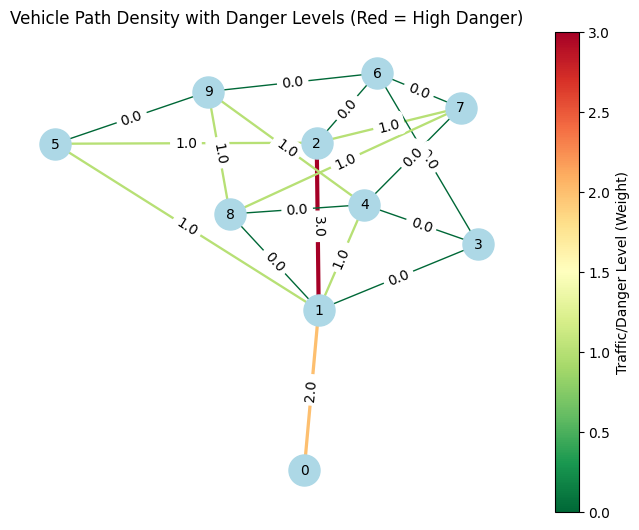

In [308]:
plot_density_graph(G, sampleset_final.first.sample, optimal_paths)

## Traffic Signal Optimization

#### Generating Random Dataset

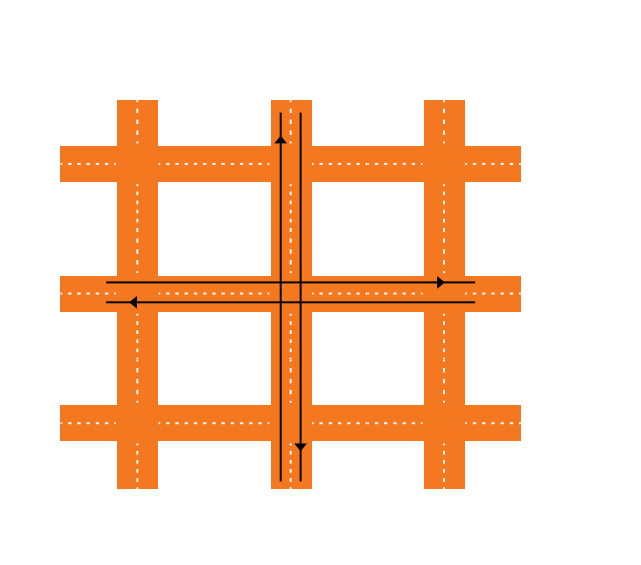

In [2]:
# Consider total 9 intersection, with focusing on middle one

In [3]:
# road[i] = [number of vechile affected when mode 1 ,2,3,4,5,6 , time taken to reach intersection connected to left, top, right, bottom, 
                                                                    # unique number of intersion connected to ith intersection at left, top,right, bottom,
#                                                                   time elapsed to mode 1, 2, 3, 4, 5, 6]
road = {}
road[0] = [5 , 10, 15, 6, 4, 10, -1, -1, 30, 60 , -1, -1, 1, 3, 20, 40, 60, 0, 80, 100]
road[1] = [7 , 11, 12, 7 , 3, 9, 30, -1, 30, 60 , 0, -1, 2, 4,0, 20, 40 ,60, 80, 100]
road[2] = [15 , 13, 13, 10 , 11, 0, 30, -1, -1, 60 , 1, -1, -1,5, 40, 60,  0, 20,80, 100]
road[3] = [9 , 15, 14, 11 , 3, 10, -1, 60, 30, 60 , -1, 0, 4, 6, 60, 0, 20, 40,100, 80]
road[4] = [11 , 1, 6, 12 , 0, 0, 30, 60, 30, 60 , 3, 1, 5, 7, 40, 20,60,0,80, 100]
road[5] = [4 , 6, 9, 1 , 3, 6, 30, 60, -1, 60 , 4, 2, -1, 8, 0, 60, 20, 40, 80, 100]
road[6] = [3 , 7, 5, 0 , 7, 9, -1, 60, 40, -1 , -1, 3, 7, -1,40,20, 0,60, 80, 100]
road[7] = [7 , 12, 4, 3 ,  11, 0, 40, 60, 40, -1 , 6, 4, 8,-1, 60,0,40, 20, 80, 100]
road[8] = [10 , 4, 10, 0 , 3, 13, 40, 60, -1, -1 , 7, 5, -1,-1, 20, 40, 60, 0, 80, 100]

In [4]:
road[2][19]

100

In [5]:
print(road)

{0: [5, 10, 15, 6, 4, 10, -1, -1, 30, 60, -1, -1, 1, 3, 20, 40, 60, 0, 80, 100], 1: [7, 11, 12, 7, 3, 9, 30, -1, 30, 60, 0, -1, 2, 4, 0, 20, 40, 60, 80, 100], 2: [15, 13, 13, 10, 11, 0, 30, -1, -1, 60, 1, -1, -1, 5, 40, 60, 0, 20, 80, 100], 3: [9, 15, 14, 11, 3, 10, -1, 60, 30, 60, -1, 0, 4, 6, 60, 0, 20, 40, 100, 80], 4: [11, 1, 6, 12, 0, 0, 30, 60, 30, 60, 3, 1, 5, 7, 40, 20, 60, 0, 80, 100], 5: [4, 6, 9, 1, 3, 6, 30, 60, -1, 60, 4, 2, -1, 8, 0, 60, 20, 40, 80, 100], 6: [3, 7, 5, 0, 7, 9, -1, 60, 40, -1, -1, 3, 7, -1, 40, 20, 0, 60, 80, 100], 7: [7, 12, 4, 3, 11, 0, 40, 60, 40, -1, 6, 4, 8, -1, 60, 0, 40, 20, 80, 100], 8: [10, 4, 10, 0, 3, 13, 40, 60, -1, -1, 7, 5, -1, -1, 20, 40, 60, 0, 80, 100]}


In [6]:
# {"Mode" : [("Direction Of Intersection (Up, down....)", ["Modes Supported by it"]]]}
l = {0 : [(1, [0,1]), (3, [0,2])], 
     1 : [(1, [0,1]), (2, [3,4])],
     2 : [(3, [0, 4]), (0, [3,5])],
     3 : [(2, [3,4]) , (0, [3,5])],
     4 : [(2, [3, 4]), (3, [0,2])],
     5 : [(1, [0,1]), (0, [3,5])]
    }

In [7]:
def supp_inter(road_dict):
    bqm_t_supp = BQM("BINARY")

    
    for key, value in road_dict.items():
        for i in range(6):
            bqm_t_supp.add_linear(f"i_{key}_M{i}", road_dict[key][i])

    
    for key, values in road_dict.items():

        # Mode 1
        time = values[14]
        if values[7] != -1 and (values[7] < time or time%values[7] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M0", f"i_{values[11]}_M0", round(1*(1/values[7])*values[0], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M0", f"i_{values[11]}_M1", round(1*(1/values[7])*values[0], 2))
            
        if values[9] != -1 and (values[9] < time or time%values[9] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M0", f"i_{values[13]}_M0", round(1*(1/values[9])*values[0], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M0", f"i_{values[13]}_M2", round(1*(1/values[9])*values[0], 2))

        # Mode 2

        time = values[15]
        if values[7] != -1 and (values[7] < time or time%values[7] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M1", f"i_{values[11]}_M0", round(1*(1/values[7])*values[1], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M1", f"i_{values[11]}_M1", round(1*(1/values[7])*values[1], 2))
            
        if values[8] != -1 and (values[8] < time or time%values[8] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M1", f"i_{values[12]}_M3", round(1*(1/values[8])*values[1], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M1", f"i_{values[12]}_M4", round(1*(1/values[8])*values[1], 2))

        # Mode 3

        time = values[16]
        if values[9] != -1 and (values[9] < time or time%values[9] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M2", f"i_{values[13]}_M0", round(1*(1/values[9])*values[2], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M2", f"i_{values[13]}_M4", round(1*(1/values[9])*values[2], 2))
            
        if values[6] != -1 and (values[6] < time or time%values[6] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M2", f"i_{values[10]}_M3", round(1*(1/values[6])*values[2], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M2", f"i_{values[10]}_M5", round(1*(1/values[6])*values[2], 2))

        # Mode 4

        time = values[17]
        if values[8] != -1 and (values[8] < time or time%values[8] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M3", f"i_{values[12]}_M3", round(1*(1/values[8])*values[3], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M3", f"i_{values[12]}_M4", round(1*(1/values[8])*values[3], 2))
            
        if values[6] != -1  and (values[6] < time or time%values[6] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M3", f"i_{values[10]}_M3", round(1*(1/values[6])*values[3], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M3", f"i_{values[10]}_M5", round(1*(1/values[6])*values[3], 2))

        # Mode 5

        time = values[18]
        if values[8] != - 1 and (values[8] < time or time%values[8] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M4", f"i_{values[12]}_M3", round(1*(1/values[8])*values[4], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M4", f"i_{values[12]}_M4", round(1*(1/values[8])*values[4], 2))
            
        if values[9] != -1 and (values[9] < time or time%values[9] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M4", f"i_{values[13]}_M0", round(1*(1/values[9])*values[4], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M4", f"i_{values[13]}_M2", round(1*(1/values[9])*values[4], 2))

        
        # Mode 6

        time = values[19]
        if values[7] != -1 and (values[7] < time or time%values[7] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M5", f"i_{values[11]}_M0", round(1*(1/values[7])*values[5], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M5", f"i_{values[11]}_M1", round(1*(1/values[7])*values[5], 2))
            
        if values[6] != -1 and (values[6] < time or time%values[6] <= 10):
            bqm_t_supp.add_quadratic(f"i_{key}_M5", f"i_{values[10]}_M3", round(1*(1/values[6])*values[5], 2))
            bqm_t_supp.add_quadratic(f"i_{key}_M5", f"i_{values[10]}_M5", round(1*(1/values[6])*values[5], 2))
        
    
    return bqm_t_supp

In [8]:
bqm_inter = supp_inter(road)

In [9]:
cqm_signal = CQM()

In [10]:
cqm_signal.set_objective(bqm_inter)

In [444]:
print(cqm_signal)

Constrained quadratic model: 54 variables, 0 constraints, 157 biases

Objective
  5*Binary('i_0_M0') + 10*Binary('i_0_M1') + 15*Binary('i_0_M2') + 6*Binary('i_0_M3') + 4*Binary('i_0_M4') + 10*Binary('i_0_M5') + 7*Binary('i_1_M0') + 11*Binary('i_1_M1') + 12*Binary('i_1_M2') + 7*Binary('i_1_M3') + 3*Binary('i_1_M4') + 9*Binary('i_1_M5') + 15*Binary('i_2_M0') + 13*Binary('i_2_M1') + 13*Binary('i_2_M2') + 10*Binary('i_2_M3') + 11*Binary('i_2_M4') + 0*Binary('i_2_M5') + 9*Binary('i_3_M0') + 15*Binary('i_3_M1') + 14*Binary('i_3_M2') + 11*Binary('i_3_M3') + 3*Binary('i_3_M4') + 10*Binary('i_3_M5') + 11*Binary('i_4_M0') + Binary('i_4_M1') + 6*Binary('i_4_M2') + 12*Binary('i_4_M3') + 4*Binary('i_5_M0') + 6*Binary('i_5_M1') + 9*Binary('i_5_M2') + Binary('i_5_M3') + 3*Binary('i_5_M4') + 6*Binary('i_5_M5') + 3*Binary('i_6_M0') + 7*Binary('i_6_M1') + 5*Binary('i_6_M2') + 7*Binary('i_6_M4') + 9*Binary('i_6_M5') + 7*Binary('i_7_M0') + 12*Binary('i_7_M1') + 4*Binary('i_7_M2') + 3*Binary('i_7_M3') + 11

In [445]:
def constr(num_interaction):
    for i in range(num_interaction):
        constraint = BQM("BINARY")
        for j in range(6):
            constraint.add_linear(f"i_{i}_M{j}", 1)
        cqm_signal.add_constraint(constraint, "==", 1, f"i_{i}")

In [446]:
constr(9)

In [447]:
print(cqm_signal)

Constrained quadratic model: 54 variables, 9 constraints, 211 biases

Objective
  5*Binary('i_0_M0') + 10*Binary('i_0_M1') + 15*Binary('i_0_M2') + 6*Binary('i_0_M3') + 4*Binary('i_0_M4') + 10*Binary('i_0_M5') + 7*Binary('i_1_M0') + 11*Binary('i_1_M1') + 12*Binary('i_1_M2') + 7*Binary('i_1_M3') + 3*Binary('i_1_M4') + 9*Binary('i_1_M5') + 15*Binary('i_2_M0') + 13*Binary('i_2_M1') + 13*Binary('i_2_M2') + 10*Binary('i_2_M3') + 11*Binary('i_2_M4') + 0*Binary('i_2_M5') + 9*Binary('i_3_M0') + 15*Binary('i_3_M1') + 14*Binary('i_3_M2') + 11*Binary('i_3_M3') + 3*Binary('i_3_M4') + 10*Binary('i_3_M5') + 11*Binary('i_4_M0') + Binary('i_4_M1') + 6*Binary('i_4_M2') + 12*Binary('i_4_M3') + 4*Binary('i_5_M0') + 6*Binary('i_5_M1') + 9*Binary('i_5_M2') + Binary('i_5_M3') + 3*Binary('i_5_M4') + 6*Binary('i_5_M5') + 3*Binary('i_6_M0') + 7*Binary('i_6_M1') + 5*Binary('i_6_M2') + 7*Binary('i_6_M4') + 9*Binary('i_6_M5') + 7*Binary('i_7_M0') + 12*Binary('i_7_M1') + 4*Binary('i_7_M2') + 3*Binary('i_7_M3') + 11

In [448]:
cqm_signal_solver = LeapHybridCQMSampler(token = "your-api-key")     

In [449]:
sampleset_signal = cqm_solver.sample_cqm(cqm_signal)

In [450]:
print(sampleset_signal)

    i_0_M0 i_0_M1 i_0_M2 i_0_M3 i_0_M4 i_0_M5 ... i_8_M5 energy num_oc. ...
29     0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    4.0       1 ...
103    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    4.0       1 ...
104    0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    4.0       1 ...
105    0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    4.0       1 ...
106    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    4.0       1 ...
107    0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    4.0       1 ...
108    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    5.0       1 ...
109    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    5.0       1 ...
110    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    5.0       1 ...
111    0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    6.0       1 ...
112    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0    7.0       1 ...
113    0.0    0.0    0.0    0.0    0.0    0.0 ...    0.0    7.0       1 ...
16     0.0  

In [451]:
final_signal = sampleset_signal.filter(lambda d: d.is_feasible)

In [452]:
print(final_signal)

   i_0_M0 i_0_M1 i_0_M2 i_0_M3 i_0_M4 i_0_M5 ... i_8_M5 energy num_oc. ...
0     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
1     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
2     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
3     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
4     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
5     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
6     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
7     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
8     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
9     0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
10    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
11    0.0    0.0    0.0    0.0    1.0    0.0 ...    0.0  11.16       1 ...
12    0.0    0.0    0.0  

In [453]:
final_signal.first.sample

{'i_0_M0': np.float64(0.0),
 'i_0_M1': np.float64(0.0),
 'i_0_M2': np.float64(0.0),
 'i_0_M3': np.float64(0.0),
 'i_0_M4': np.float64(1.0),
 'i_0_M5': np.float64(0.0),
 'i_1_M0': np.float64(0.0),
 'i_1_M1': np.float64(0.0),
 'i_1_M2': np.float64(0.0),
 'i_1_M3': np.float64(0.0),
 'i_1_M4': np.float64(1.0),
 'i_1_M5': np.float64(0.0),
 'i_2_M0': np.float64(0.0),
 'i_2_M1': np.float64(0.0),
 'i_2_M2': np.float64(0.0),
 'i_2_M3': np.float64(0.0),
 'i_2_M4': np.float64(0.0),
 'i_2_M5': np.float64(1.0),
 'i_3_M0': np.float64(0.0),
 'i_3_M1': np.float64(0.0),
 'i_3_M2': np.float64(0.0),
 'i_3_M3': np.float64(0.0),
 'i_3_M4': np.float64(1.0),
 'i_3_M5': np.float64(0.0),
 'i_4_M0': np.float64(0.0),
 'i_4_M1': np.float64(0.0),
 'i_4_M2': np.float64(0.0),
 'i_4_M3': np.float64(0.0),
 'i_4_M4': np.float64(0.0),
 'i_4_M5': np.float64(1.0),
 'i_5_M0': np.float64(0.0),
 'i_5_M1': np.float64(0.0),
 'i_5_M2': np.float64(0.0),
 'i_5_M3': np.float64(1.0),
 'i_5_M4': np.float64(0.0),
 'i_5_M5': np.float6

In [458]:
sampleset_signal.data("energy")

<generator object SampleSet.data at 0x000001560069AAC0>